# Bayesian Supply Chain Example

In [1]:
%matplotlib inline

import pymc3 as pm
import theano.tensor as tt
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
import arviz as az
import matplotlib.pyplot as plt

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

/Users/robertparkin/anaconda3/lib/python3.7/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/Users/robertparkin/anaconda3/lib/python3.7/site-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)



## Supply chain optimization problem

There are three suppliers we can order a part from. These suppliers have different prices, different quality items, and different maximum amounts they can ship us within a certain timeframe. We know the prices and max order sizes, but the true yield distribution is unobserverable. Here, we include the unobservable parameters SUPPLIER_YIELD and SUPPLIER_YIELD_SD to simulate data, but we will assume we don't know them. SUPPLIER_YIELD is the mean yield of a given supplier while SUPPLIER_YIELD_SD is the standard deviation away from the mean. The standard deviation gives you a simple measure of the variability of the supply from that supplier.

In this case, the first supplier will be more expensive ($220) but will be more reliable (lower SD) and have the highest max order size. Supplier #2 is the least reliable and has the lowest ability to supply but is also significantly lower in cost.


In [2]:
SUPPLIER_YIELD = np.array([.9, .5, .8]) # unknown
SUPPLIER_YIELD_SD = np.array([.1, .2, .2]) # unknown
PRICES = [220.0, 100.0, 120.0] # known
MAX_ORDER_SIZE = [110, 80, 100] # known


The yield represents the percentage of parts that pass our quality test and arrive on time. Due to different manufacturing techniques, the yield varies quite a bit, which is also reflected in the price. As we assume that we can't directly observe the true yield, we will have to estimate it from previous batches we ordered. Let's assume we have ordered different times from different suppliers. For example, as supplier 2 (third list item) only opened up recently, we only ordered twice from there:

In [3]:
N_OBS = [30, 20, 2]

In [4]:
np.random.seed(100)
data = []
for supplier_yield, supplier_yield_sd, n_obs in zip(SUPPLIER_YIELD, SUPPLIER_YIELD_SD, N_OBS):
    data.append(pm.Beta.dist(mu=supplier_yield, sd=supplier_yield_sd, shape=n_obs).random())
    
data

[array([0.978235  , 0.98946102, 0.99035051, 0.83762708, 0.66130327,
        0.98785994, 0.85327018, 0.8500779 , 0.99913878, 0.89881072,
        0.8175994 , 0.95181804, 0.91545214, 0.87137954, 0.96166603,
        0.99033823, 0.96319861, 0.94124979, 0.96555922, 0.96606356,
        0.92723444, 0.97736913, 0.86764773, 0.81749131, 0.98597604,
        0.97980665, 0.77295709, 0.9584931 , 0.88875261, 0.99585613]),
 array([0.51788973, 0.67831661, 0.64888304, 0.61595363, 0.08634205,
        0.72543455, 0.51883833, 0.5454235 , 0.30357696, 0.21743938,
        0.54628383, 0.68559965, 0.28827533, 0.79246239, 0.65810975,
        0.69059483, 0.59297579, 0.85482231, 0.38115298, 0.8296909 ]),
 array([0.89241857, 0.9000698 ])]

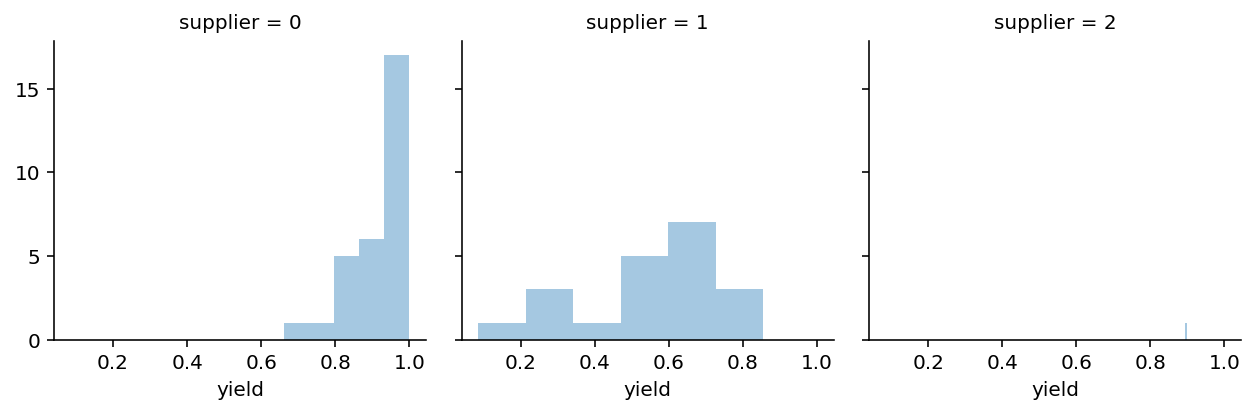

In [5]:
data_df = pd.DataFrame(data).T
data_tidy = data_df.unstack().to_frame('yield')
data_tidy.index = data_tidy.index.set_names(['supplier', 'obs'])
g = sns.FacetGrid(data=data_tidy.reset_index().dropna(), col='supplier')
g.map(sns.distplot, 'yield', kde=False);



So this is the data we have available to try and estimate the true yield of every supplier.
Quick note on the generality of this problem

Almost every retailer (like Amazon) has this problem of deciding how much to order given yield and holding cost. A similar problem also occurs in insurance where you need to sell contracts which have some risk of becoming claims. Or in online advertising where you need to decide how much to bid on clicks given a budget. Even if you don't work on these industries, the cost of any inefficiencies gets passed onto you, the customer! We also had a similar problem at Quantopian when deciding which algorithms to select in our fund and how much capital to deploy to each one. 


## The Dynamics of the Supply Chain

In order to assess how many parts we need we first need to know how many final products we can sell. If we buy too few we are leaving money on the table, if we buy too many we will have to put them in storage which costs money (HOLDING_COST). Let's assume we can sell a product for $500 and it costs us $100 to stock the product in inventory.


In [6]:
SALES_PRICE = 500 
HOLDING_COST = 100

Next, let's define our loss function which takes as inputs how many engines we have in stock, how many final customers want, at what price we bought the engine, at what price we can sell the product, and what the holding costs are per product:

In [7]:
@np.vectorize
def loss(in_stock, demand, buy_price, sales_price=SALES_PRICE, holding_cost=HOLDING_COST):
    # How much do we earn per product
    margin = sales_price - buy_price
    # Do we have more in stock than demanded?
    if in_stock > demand:
        total_profit = demand * margin
        # everything left over after demand was met goes into holding
        total_holding_cost = (in_stock - demand) * holding_cost
        reward = total_profit - total_holding_cost
    else:
        # Can only sell what we have in stock, no storage required
        reward = in_stock * margin
    
    # Usually we minimize, so invert
    return -reward

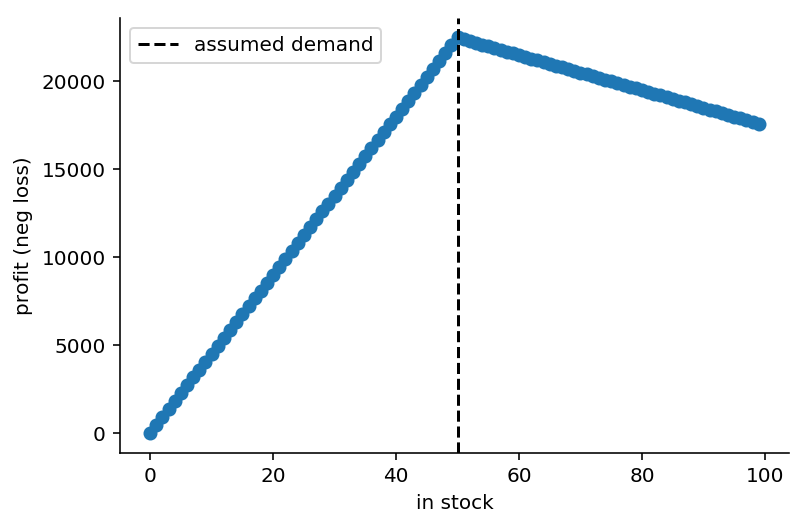

In [8]:
in_stock = np.arange(0, 100)
plt.scatter(in_stock, -loss(in_stock, 50, 50)); plt.axvline(50, c='k', ls='--', label='assumed demand');
plt.xlabel('in stock'); plt.ylabel('profit (neg loss)'); sns.despine(); plt.legend();




As you can see, if customer demand is 50, we maximize our profit if we have only 50 items in stock. Having fewer eats into our profits at a greater rate than ordering excess product because in this setup our margins are larger than the holding cost.

Next, we need our estimate of demand. As we have a long history of sales we have a pretty good idea of what the distribution looks like, but we will also assume that we don't know the true underlying parameters and only have access to the samples:


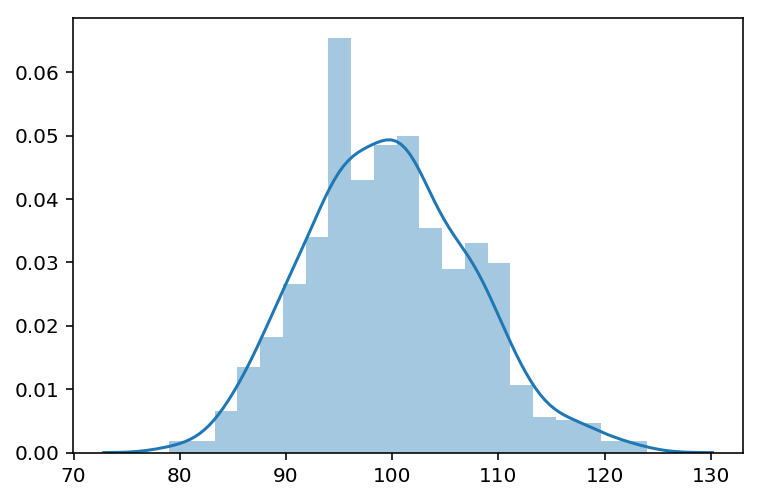

In [9]:
demand_samples = stats.poisson(60, 40).rvs(1000)
sns.distplot(demand_samples);

We can evaluate our objective function over every demand we observed historically (setting parts in stock to 100):

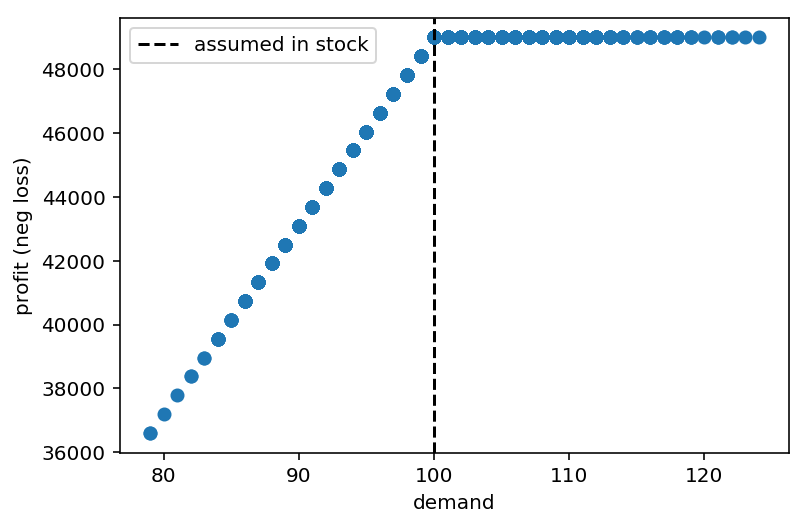

In [10]:
plt.scatter(demand_samples, -loss(in_stock=100, demand=demand_samples, buy_price=10))
plt.xlabel('demand'); plt.ylabel('profit (neg loss)'); plt.axvline(100, c='k', ls='--', label='assumed in stock');
plt.legend();

In response to demand, the loss-function behaves differently: with less demand than what we have in stock, we earn less (because we sell fewer final products but also have to pay holding costs), but as demand exceeds the number of parts we have in stock our profit stays flat because we can't sell more than what we have.


## Estimating yield with a Bayesian model

Let's build a model to estimate the yield of every engine supplier:


In [11]:
with pm.Model() as model:
    # Priors on alpha and beta parameters for each supplier
    α = pm.HalfNormal('α', sd=10., shape=3)
    β = pm.HalfNormal('β', sd=10., shape=3)
    
    # Different likelihood for every supplier because we have different
    # number of data points
    for i, d in enumerate(data):
        pm.Beta(f'supplier_yield_obs_{i}', 
            alpha=α[i], beta=β[i],
            observed=d)
    
    trace = pm.sample()


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [β, α]
Sampling 4 chains: 100%|██████████| 4000/4000 [00:03<00:00, 1198.61draws/s]


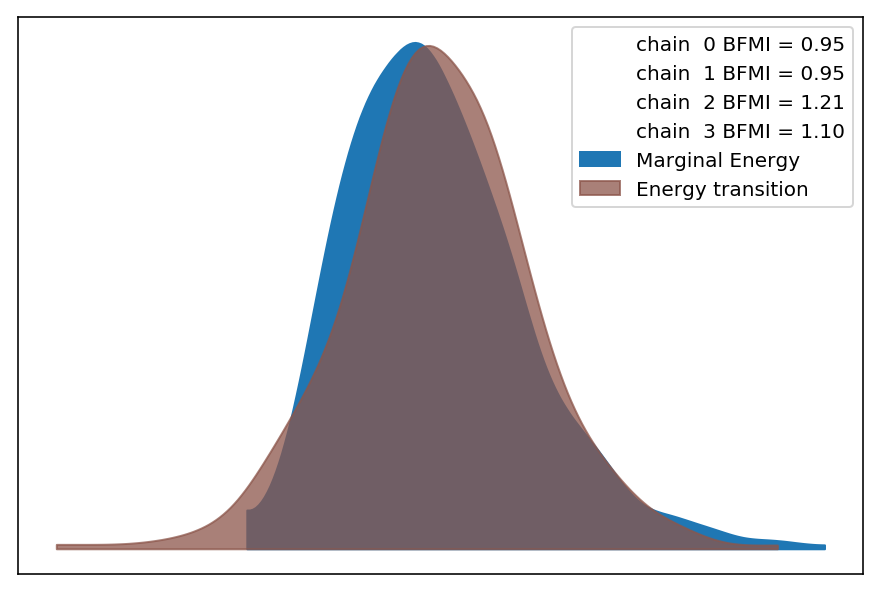

In [12]:
# make sure convergence looks good
az.plot_energy(trace);



## Generate possible future scenarios

In order to perform Bayesian Decision Making we need an estimate of what the future might look like. As we are in a generative framework this is trivial: we just need to sample from the posterior predictive distribution of our model which generates new data based on our estimated posteriors.


In [13]:
with model:
    post_pred = pm.sample_posterior_predictive(trace, 1000)


100%|██████████| 1000/1000 [00:01<00:00, 801.60it/s]


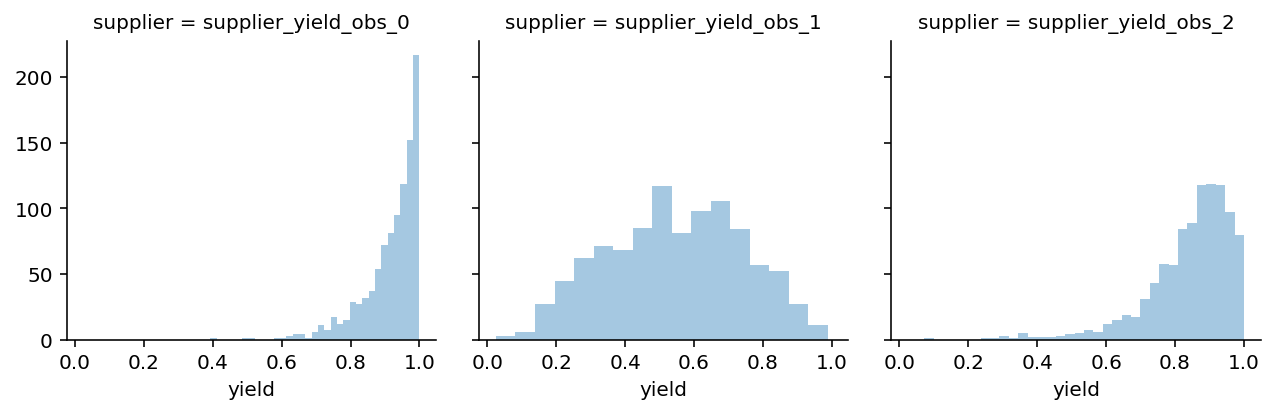

In [14]:
supplier_yield_post_pred = pd.DataFrame({k: v[:, 1] for k, v in post_pred.items()})
data_tidy = supplier_yield_post_pred.unstack().to_frame('yield')
data_tidy.index = data_tidy.index.set_names(['supplier', 'obs'])
g = sns.FacetGrid(data=data_tidy.reset_index().dropna(), col='supplier')
g.map(sns.distplot, 'yield', kde=False);



This plot shows, given the data and our model, what we can expect to observe. Note that these predictions take the uncertainty into account. For supplier 2 we have a lot of uncertainty because we only observed very few data points.

Given these estimates we can write a function that converts the orders we place to each supplier, the yield we assume for each one, and what their prices are.


In [15]:
def calc_yield_and_price(orders, 
                         supplier_yield=np.array([.9, .5, .8]),
                         prices=PRICES
                        ):
    orders = np.asarray(orders)
    
    full_yield = np.sum(supplier_yield * orders)
    price_per_item = np.sum(orders * prices) / np.sum(orders)
    
    return full_yield, price_per_item

calc_yield_and_price([100, 60, 60])


(168.0, 160.0)



So given these (randomly picked) order amounts to each supplier and some deterministic yield, we would receive 168 functioning parts at an effective price of $160 each.

## Bayesian Decision Making

Now we have to actually do the optimization. First, we need to specify our objective function which will compute the total yield and effective price given a posterior predictive sample. Once we have that and our demand (also a sample from that distribution), we can compute our loss. As we have a distribution over possible scenarios, we compute the loss for each one and return the distribution.


In [16]:
def objective(orders, supplier_yield=supplier_yield_post_pred,
              demand_samples=demand_samples, max_order_size=MAX_ORDER_SIZE):
    orders = np.asarray(orders)
    losses = []
    
    # Negative orders are impossible, indicated by np.inf
    if np.any(orders < 0):
        return np.inf
    # Ordering more than the supplier can ship is also impossible
    if np.any(orders > MAX_ORDER_SIZE):
        return np.inf
    
    # Iterate over post pred samples provided in supplier_yield
    for i, supplier_yield_sample in supplier_yield.iterrows():
        full_yield, price_per_item = calc_yield_and_price(
            orders,
            supplier_yield=supplier_yield_sample
        )
        
        # evaluate loss over each sample with one sample from the demand distribution
        loss_i = loss(full_yield, demand_samples[i], price_per_item)
        
        losses.append(loss_i)
        
    return np.asarray(losses)

Great, we have all our required functions, let's put things into an optimizer and see what happens.

In [17]:
from scipy import optimize

# parameters for the optimization, we're just including the max order sizes as bounds
bounds = [(0, max_order) for max_order in MAX_ORDER_SIZE]
starting_value = [50., 50., 50.]

In [18]:
# minimize the expected loss under all possible scenarios
opt_stoch = optimize.minimize(lambda *args: np.mean(objective(*args)), 
                              starting_value, 
                              bounds=bounds)

In [19]:
print('Optimal order amount from every supplier = {}'.format(np.ceil(opt_stoch.x)))

Optimal order amount from every supplier = [ 0. 80. 93.]


In [20]:


print('Total order amount from all suppliers = {}'.format(np.ceil(np.sum(opt_stoch.x))))



Total order amount from all suppliers = 173.0


Great, we did it! Excitedly you go to your manager and tell her the amazing model you built and the optimal order amounts. Unfortunately, she is not impressed and asks "that's some fancy technique, but I'm not convinced this is actually better than what we currently use which is to just take the means of the yield distribution for each supplier."

## Evaluation

Slightly discouraged you go back to your desk and wonder why life is so unfair and you actually have to prove that things work and why "but it's Bayesian!" is not as convincing an argument as you hoped for. After some deep reflection you come to the conclusion that your manager might have a point and that additional complexity must be warranted and demonstrably better. To build a more compelling case, you decide to compare the naive method of just using the means to your fancy method in terms of expected profit in a simulation study.

Instead of samples from the posterior predictive, we can just pass a single sample -- the mean -- into our objective function.

In [21]:
supplier_yield_mean = pd.DataFrame([np.mean(d) for d in data]).T
supplier_yield_mean

,0,1,2
0,0.918735,0.558903,0.896244


As well as the demand we expect on average (100). This way we can still use the above objective function but the loop will just run once.

In [22]:
opt_non_stoch = optimize.minimize(lambda *args: objective(*args, 
                                                          supplier_yield=supplier_yield_mean, 
                                                          demand_samples=[100]), 
                                  starting_value, 
                                  bounds=bounds)


In [23]:
print('Optimal order amount from every supplier = {}'.format(np.ceil(opt_non_stoch.x)))

Optimal order amount from every supplier = [42. 46. 42.]


In [24]:
print('Total order amount from all suppliers = {}'.format(np.ceil(np.sum(opt_non_stoch.x))))

Total order amount from all suppliers = 128.0




The results are certainly different. The full Bayesian treatment seems to dislike our high-cost but high-quality supplier. It also orders more in total (probably to account for the lower yield of the other two suppliers). But which one is actually better in terms of our profit?

To answer that question, we will generate new data from our generative model and compute the profit in each new scenario given the order amounts from the two optimizations.


In [25]:
np.random.seed(123)
data_new = []
for supplier_yield, supplier_yield_sd, n_obs in zip(SUPPLIER_YIELD, SUPPLIER_YIELD_SD, N_OBS):
    data_new.append(pm.Beta.dist(mu=supplier_yield, sd=supplier_yield_sd, shape=1000).random())
data_new = pd.DataFrame(data_new).T
data_new.head().add_prefix("Supplier ")

,Supplier 0,Supplier 1,Supplier 2
0,0.880298,0.752686,0.997934
1,0.698046,0.307304,0.971085
2,0.676807,0.534287,0.891209
3,0.943773,0.666368,0.975907
4,0.911538,0.457898,0.556483


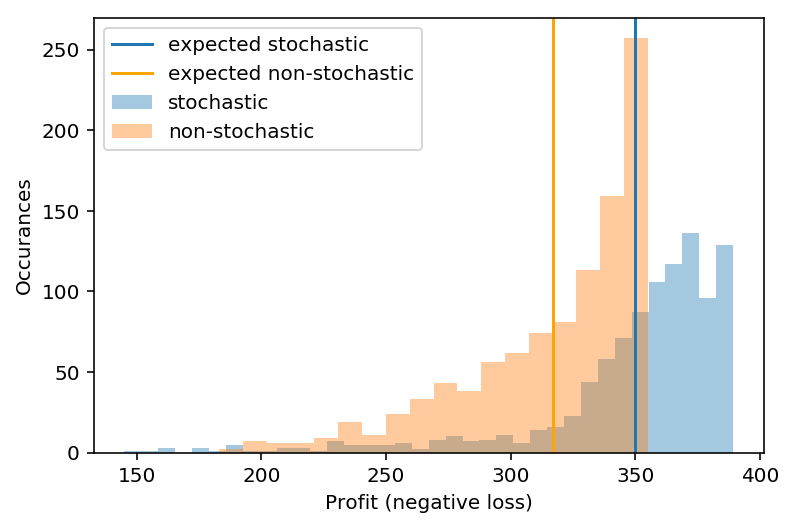

In [26]:
neg_loss_stoch = -objective(opt_stoch.x, supplier_yield=data_new) / demand_samples
neg_loss_non_stoch = -objective(opt_non_stoch.x, supplier_yield=data_new) / demand_samples
sns.distplot(neg_loss_stoch, label='stochastic', kde=False)
plt.axvline(np.mean(neg_loss_stoch), label='expected stochastic')
sns.distplot(neg_loss_non_stoch, label='non-stochastic', kde=False)
plt.axvline(np.mean(neg_loss_non_stoch), color='orange', label='expected non-stochastic')
plt.legend(); plt.xlabel('Profit (negative loss)'); plt.ylabel('Occurances');


In [27]:
print('Expected profit of Bayesian model = $%.2f ' % np.mean(neg_loss_stoch))

Expected profit of Bayesian model = $349.87 


In [28]:
print('Expected profit of naive model = $%.2f' % np.mean(neg_loss_non_stoch))


Expected profit of naive model = $317.01




Your manager is very pleased that you finally speak her language and demonstrated an expected 10% increase in profit, which translates to millions of additional profit over a year at the scale the business operates on. 

## Summary

As you can see, once we have a Bayesian model and an objective function we can apply Bayesian Decision Theory to make better decisions. Why better? While there is a mathematical proof that shows this to be optimal, there are also more practical and intuitive reasons. The first major reason is that we do not just optimize over the most likely future scenario, but all possible future scenarios.

Second, as we did the optimization just using samples rather probability distributions we don't have to do any integration (see this great blog post for an introduction). This gives us huge flexibility in our approach as we can arbitrarily extend our models but still use the same framework. For example, we could use the Prophet forecasting model to forecast demand more accurately. Or we could extend our yield estimation model to be hierarchical.